# 1. Loading Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

plt.style.use('ggplot')

In [2]:
# Downloaded these files for NLTK
# import nltk
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('maxent_ne_chunker_tab')
# nltk.download('words')
# nltk.download('vader_lexicon')

In [ ]:
# Read in data
df = pd.read_csv('../data/FoodReview.csv')
df.shape

(568454, 10)

In [4]:
df = df.head(10000)
print(df.shape)

(10000, 10)


In [5]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# 2. EDA

In [6]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [7]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [9]:
df['Score'].value_counts()

Score
5    6183
4    1433
1     932
3     862
2     590
Name: count, dtype: int64

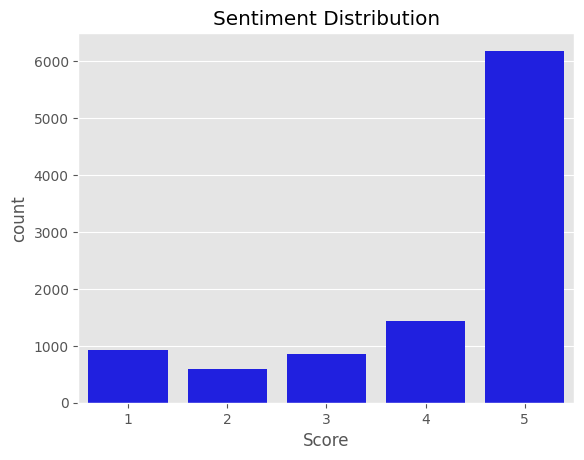

In [10]:
sns.countplot(x='Score', data=df, color='Blue')
plt.title('Sentiment Distribution')
plt.show()

# 3. Basic NLTK

In [11]:
example = df['Text'][91]
print(example)

This is great dog food, my dog has severs allergies and this brand is the only one that we can feed him.


In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'is', 'great', 'dog', 'food', ',', 'my', 'dog', 'has', 'severs']

In [13]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('great', 'JJ'),
 ('dog', 'JJ'),
 ('food', 'NN'),
 (',', ','),
 ('my', 'PRP$'),
 ('dog', 'NN'),
 ('has', 'VBZ'),
 ('severs', 'NNS')]

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  great/JJ
  dog/JJ
  food/NN
  ,/,
  my/PRP$
  dog/NN
  has/VBZ
  severs/NNS
  allergies/NNS
  and/CC
  this/DT
  brand/NN
  is/VBZ
  the/DT
  only/JJ
  one/NN
  that/IN
  we/PRP
  can/MD
  feed/VB
  him/PRP
  ./.)


# 4. VADER Sentiment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [17]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'compound': 0.6249}

In [19]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid]  = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how='left')

In [21]:
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Plot VADER results

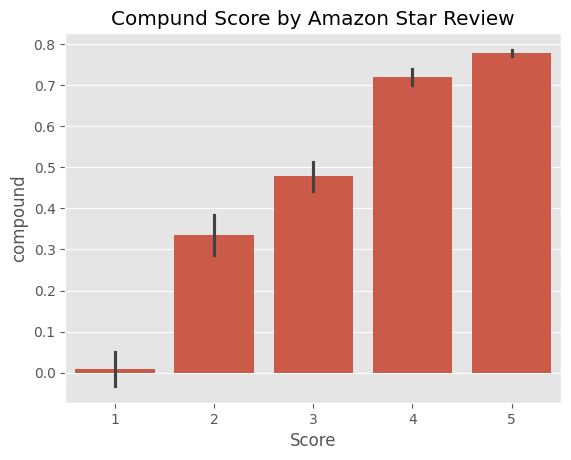

In [22]:
ax = sns.barplot(data=vaders, x='Score',y = 'compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

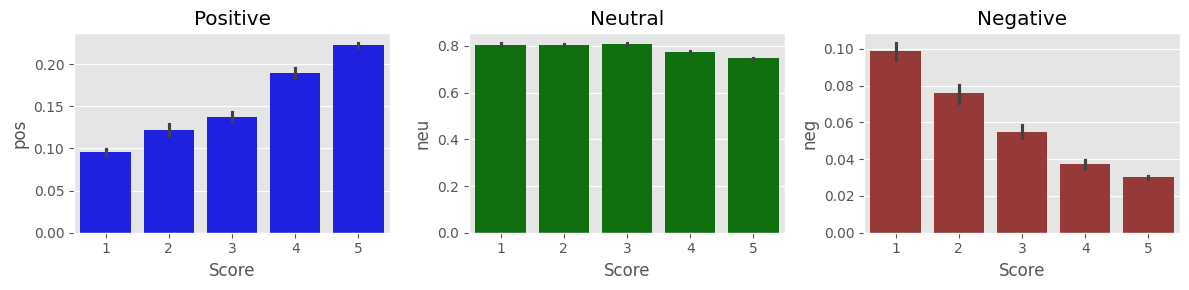

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0],color='Blue')
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1],color='Green')
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2],color='brown')

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# 5. Roberta Pretrained Model

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This is great dog food, my dog has severs allergies and this brand is the only one that we can feed him.


{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'compound': 0.6249}

In [27]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.007930269, 'roberta_neu': 0.044241488, 'roberta_pos': 0.94782823}


In [28]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [29]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583
Broke for id 5040
Broke for id 5182
Broke for id 5192
Broke for id 5365
Broke for id 5442
Broke for id 5709
Broke for id 5998
Broke for id 6003
Broke for id 6007
Broke for id 6106
Broke for id 6234
Broke for id 6558

In [30]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index' : "Id"})
results_df = results_df.merge(df, how='left')

# 6. Compare Scores between models

In [31]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## 6.1  Visualization

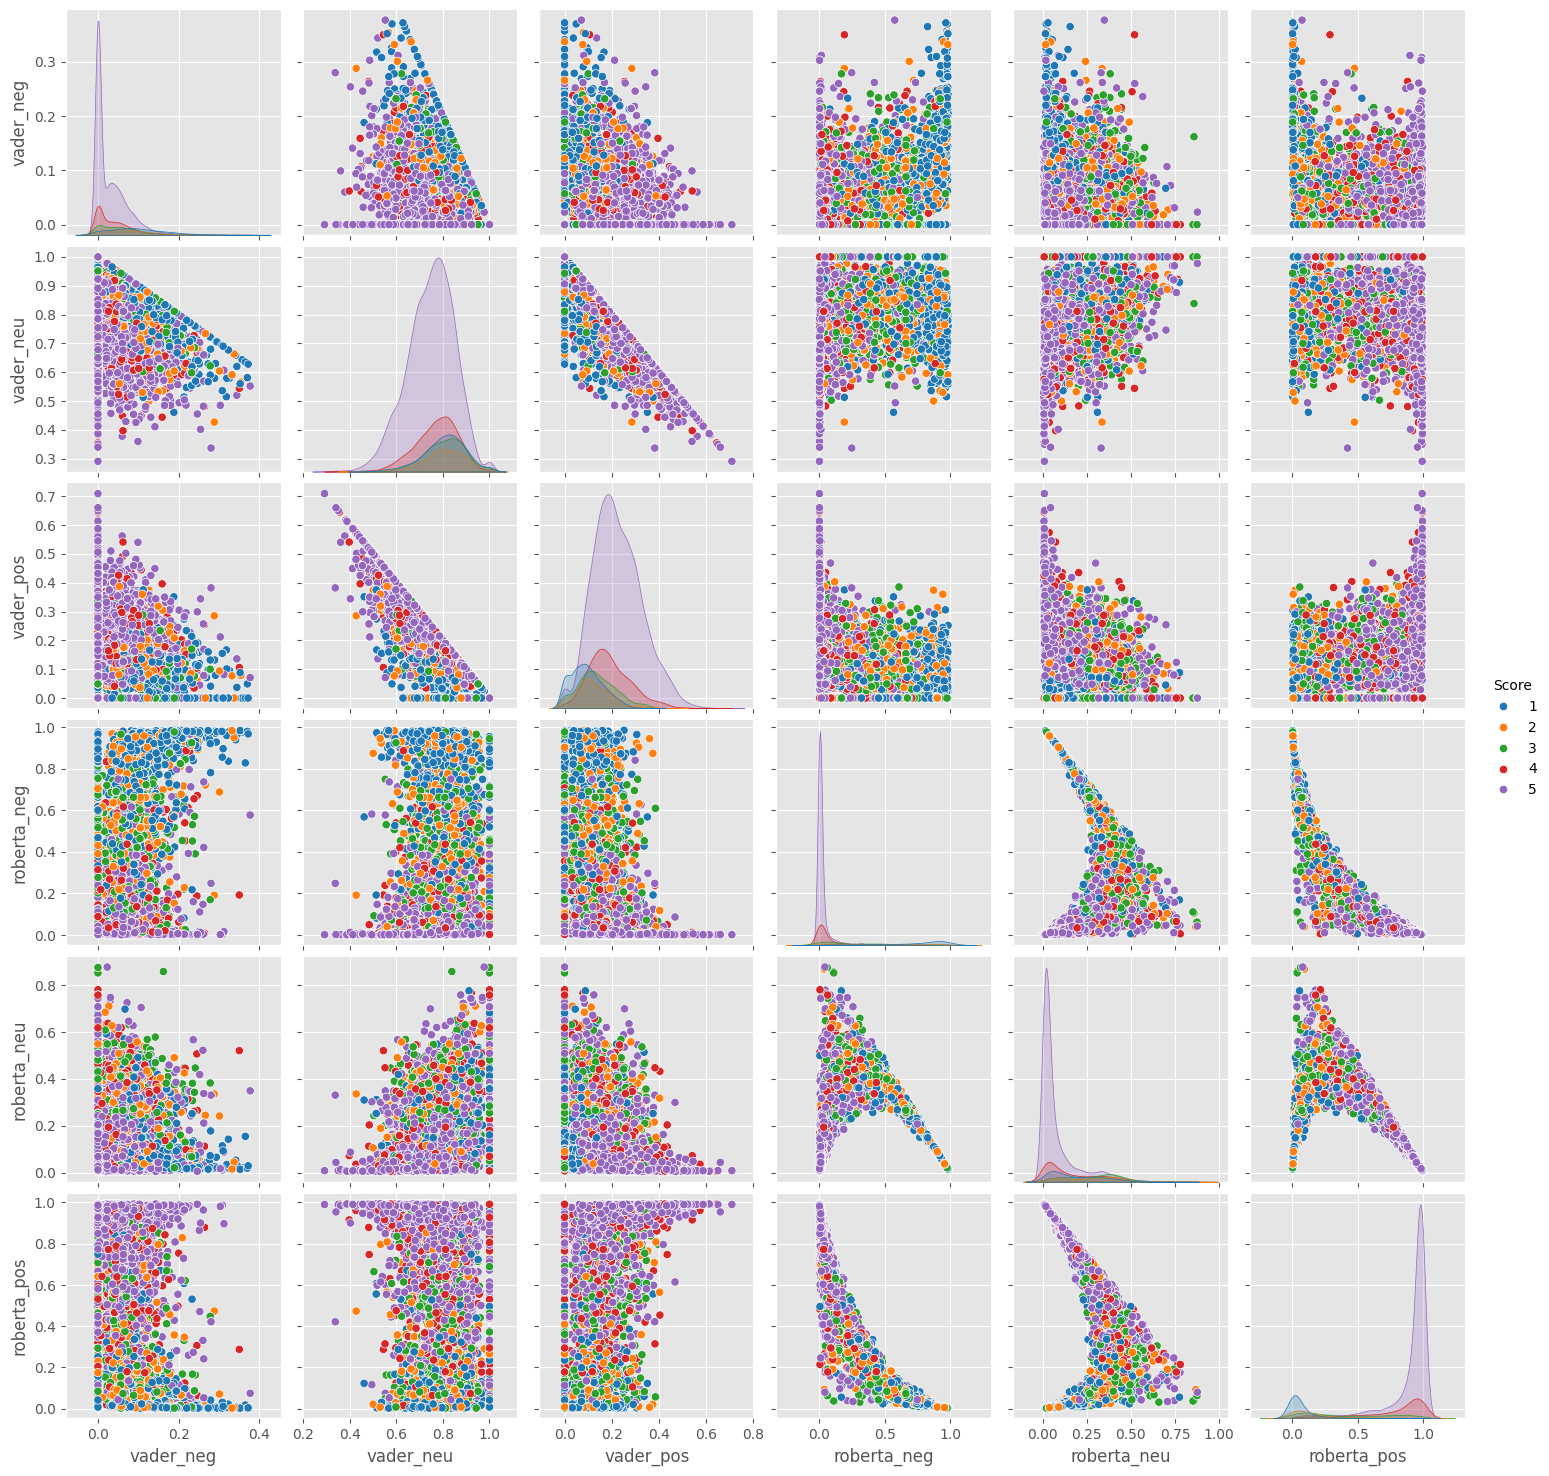

In [32]:
sns.pairplot(data=results_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## 6.2 Review Examples:
Positive 1-Star and Negative 5-Star Reviews

In [33]:
results_df.query('Score==1') \
        .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [34]:
results_df.query('Score==1') \
        .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'

In [35]:
results_df.query('Score==5') \
        .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!'

In [36]:
results_df.query('Score==5') \
        .sort_values('vader_neg', ascending=False)['Text'].values[0]

'My two cats must not be interested in grass, because it grew but they ignored it. Had no problems growing it.'

# Additional: The Transformers Pipeline

In [37]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use cpu


In [38]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [39]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [40]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [43]:
sent_pipeline('not bad')

[{'label': 'POSITIVE', 'score': 0.9995881915092468}]

In [2]:
print(python.__version__)

NameError: name 'python' is not defined

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import nltk

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", mpl.__version__)
print("Seaborn version:", sns.__version__)
print("NLTK version:", nltk.__version__)

Python version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
NumPy version: 1.26.4
Pandas version: 2.2.3
Matplotlib version: 3.9.2
Seaborn version: 0.13.2
NLTK version: 3.9.1
